# Logistic Regression with Sklearn and TensorFlow Part I

In [8]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

## Load data and visualize the data

In [9]:
credit_card = pd.read_csv('creditcard.csv')

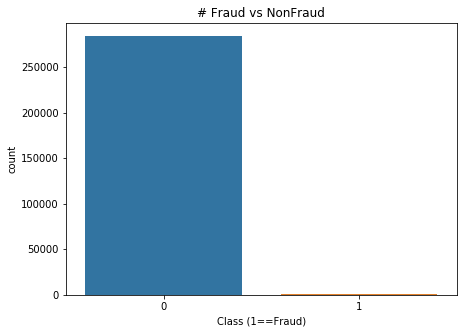

In [10]:
f, ax = plt.subplots(figsize=(7, 5))
sns.countplot(x='Class', data=credit_card)
plt.title('# Fraud vs NonFraud')
plt.xlabel('Class (1==Fraud)')
plt.savefig('inbalance_class.png', dpi=600)

As we can see we have mostly non-fraudulent transactions. Such a problem is also called inbalanced class problem.

99.8% of all transactions are non-fraudulent. The easiest classifier would always predict no fraud and would be in almost all cases correct. Such classifier would have a very high accuracy but is quite useless.

In [11]:
base_line_accuracy = 1-np.sum(credit_card.Class)/credit_card.shape[0]
base_line_accuracy

0.99827251436937992

For such an inbalanced class problem we could use over or undersampling methods to try to balance the classes (see inbalance-learn for example: https://github.com/scikit-learn-contrib/imbalanced-learn), but this out of the scope of todays post. We will come back to this in a later post.

As accuracy is not very informative in this case the AUC (Aera under the curve) a better metric to assess the model quality. The AUC in a two class classification class is equal to the probability that our classifier will detect a fraudulent transaction given one fraudulent and genuiune transaction to choice from. Guessing would have a probability of 50%.

In [12]:
X = credit_card.drop(columns='Class', axis=1)
y = credit_card.Class.values

Due to the construction of the dataset (PCA transformed features, which minimizes the correlation between factors), we dont have any highly correlated features. Multicolinearity could cause problems in a logisitc regression.

To test for multicolinearity one could look into the correlation matrix (works only for non categorical features) or run partial regressions and compare the standard errors or use pseudo-R^2 values and calculate Variance-Inflation-Factors.


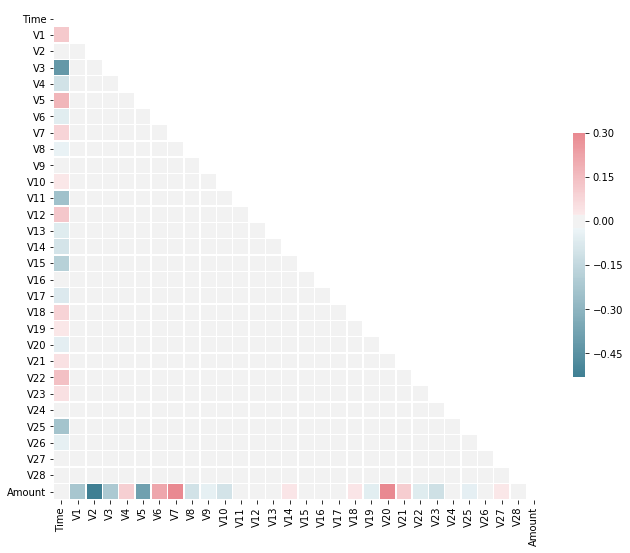

In [13]:
corr = X.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.savefig('heat_map.png', dpi=600)

## Logisitc Regression with Sklearn

Short reminder of Logistic Regression:

In Logisitic Regression the logits (logs of the odds) are assumed to be a linear function of the features

$$L=\log(\frac{P(Y=1)}{1-P(Y=1)}) = \beta_0 + \sum_{i=1}^n \beta_i X_i. $$

Solving this equatation for $p=P(Y=1)$ yields to

$$ p = \frac{\exp(L)}{1-\exp(L)}.$$

The parameters $\beta_i$ can be derived by Maximum Likelihood Estimation (MLE). The likelihood for a given $m$ observation $Y_j$ is

$$ lkl = \prod_{j=1}^m p^{Y_j}(1-p)^{1-Y_j}.$$

To find the maximum of the likelihood is equivalent to the minimize the negative logarithm of the likelihood (loglikelihood).

$$  -llkh = -\sum_{j=1}^m Y_j \log(p) + (1-Y_j) \log(1-p),$$

which is numerical more stable. The log-likelihood function has the same form as the cross-entropy error function for a discrete case.

So finding the maximum likelihood estimator is the same problem as minimizing the average cross entropy error function.

In SciKit-Learn uses by default a coordinate descent algorithm to find the minimum of L2 regularized version of the loss function (see. http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression).

The main difference between L1 (Lasso) and L2 (Ridge) regulaziation is, that the L1 prefer a sparse solution (the higher the regulazation parameter the more parameter will be zero) while L2 enforce small parameter values.

## Train the model

### Training and test set

First we split our data set into a train and a validation set by using the function train_test_split. The model performace 

In [14]:
np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(X, y)

### Model definition

As preperation we standardize our features to have zero mean and a unit standard deviation. The convergence of gradient descent algorithm are better. We use the class `StandardScaler`. The class *StandardScaler* has the method `fit_transform()` which learn the mean $\mu_i$ and standard deviation $\sigma_i$ of each feature $i$ and return a standardized version $\frac{x_i - \mu_i}{\sigma}$. We learn the mean and sd on the training data. We can apply the same standardization on the test set with the function *transform()*.


The logistic regression is implemented in the class `LogisticRegression`, we will use for now the default parameterization. The model can be fit using the function `fit()`. After fitting the model can be used to make predicitons `predict()` or return the estimated the class probabilities `predict_proba()`.

We combine both steps into a Pipeline. The pipline performs both steps automatically. When we call the method `fit()` of the pipeline, it will invoke the method `fit_and_transform()` for all but the last step and the method `fit()` of the last step, which is equivalent to:

```python
lr.fit(scaler.fit_transform(X_train), y_train)
```

or visualized as a dataflow:

```X_train => scaler.fit_transform(.) => lr.fit(., y_train)```

If we invoke the method `predict()` of the pipeline its equvivalent to


```python
lr.predict(scaler.transform(X_train))
```




In [15]:
scaler = StandardScaler()
lr = LogisticRegression()
model1 = Pipeline([('standardize', scaler),
                    ('log_reg', lr)])

In the next step we fit our model to the training data

In [16]:
model1.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('log_reg', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [17]:
### Training score and Test score

In [18]:
y_train_hat = model1.predict(X_train)
y_train_hat_probs = model1.predict_proba(X_train)[:,1]
train_accuracy = accuracy_score(y_train, y_train_hat)*100
train_auc_roc = roc_auc_score(y_train, y_train_hat_probs)*100
print('Training accuracy: %.4f %%' % train_accuracy)
print('Training AUC: %.4f %%' % train_auc_roc)

Training accuracy: 99.9237 %
Training AUC: 98.0664 %


In [19]:
y_test_hat = model1.predict(X_test)
y_test_hat_probs = model1.predict_proba(X_test)[:,1]
test_accuracy = accuracy_score(y_test, y_test_hat)*100
test_auc_roc = roc_auc_score(y_test, y_test_hat_probs)*100
print('Training accuracy: %.4f %%' % test_accuracy)
print('Training AUC: %.4f %%' % test_auc_roc)

Training accuracy: 99.9199 %
Training AUC: 97.4810 %


In [20]:
print(classification_report(y_test, y_test_hat, digits=4))

             precision    recall  f1-score   support

          0     0.9994    0.9998    0.9996     71089
          1     0.8500    0.6018    0.7047       113

avg / total     0.9991    0.9992    0.9991     71202



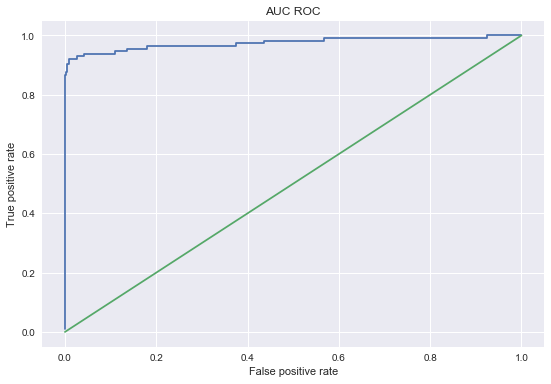

In [24]:
fpr, tpr, thresholds = roc_curve(y_test, y_test_hat_probs, drop_intermediate=True)

f, ax = plt.subplots(figsize=(9, 6))
_ = plt.plot(fpr, tpr, [0,1], [0, 1])
_ = plt.title('AUC ROC')
_ = plt.xlabel('False positive rate')
_ = plt.ylabel('True positive rate')
plt.style.use('seaborn')

plt.savefig('auc_roc.png', dpi=600)